Files already downloaded and verified
Files already downloaded and verified
---- SGD_own ----
Test Epoch 1, loss: 2.2188258563415912, accuracy: 19.34%
Test Epoch 2, loss: 2.118267764019061, accuracy: 23.65%
Test Epoch 3, loss: 1.988189039351065, accuracy: 28.52%
Test Epoch 4, loss: 1.8940955898429774, accuracy: 31.509999999999998%
Test Epoch 5, loss: 1.8136036245128777, accuracy: 34.9%
Test Epoch 6, loss: 1.766057420380508, accuracy: 36.63%
Test Epoch 7, loss: 1.7140593257131456, accuracy: 38.74%
Test Epoch 8, loss: 1.6655126297021214, accuracy: 40.57%
Test Epoch 9, loss: 1.631439619426486, accuracy: 41.56%
Test Epoch 10, loss: 1.6021765923198266, accuracy: 42.85%
Test Epoch 11, loss: 1.56381846530528, accuracy: 43.84%
Test Epoch 12, loss: 1.5314096529272538, accuracy: 45.2%
Test Epoch 13, loss: 1.5399098426480837, accuracy: 44.800000000000004%
Test Epoch 14, loss: 1.4907026034367235, accuracy: 46.79%
Test Epoch 15, loss: 1.4732168746899954, accuracy: 47.49%
Test Epoch 16, loss: 1.4677

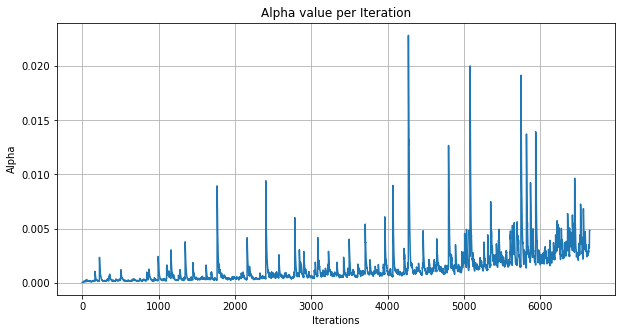

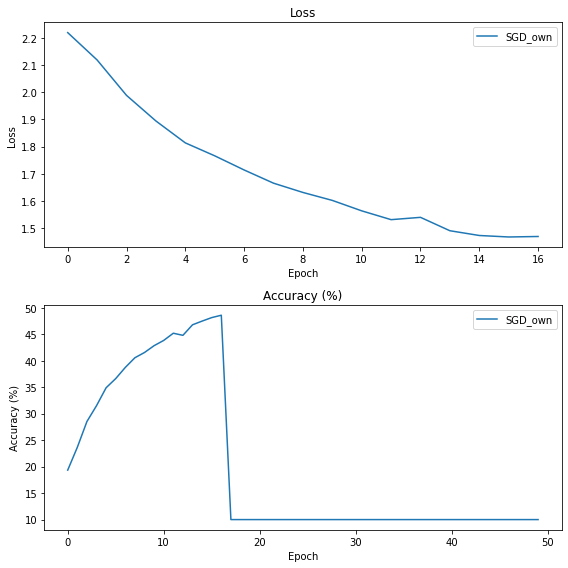

In [2]:
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torchvision.transforms as transforms
from torchvision import datasets
import copy
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt

gamma = 0.9

def compute_step_size(X, W, gradient, Y_hot):
    global past_10th_epoch

    if past_10th_epoch:
        return compute_step_size.avg_step_size * 10 ###############################

    W = W.t()

    gradient = gradient.t()
    term1 = torch.sum(torch.exp(-torch.mm(X, W)), dim=1)
    term2 = torch.sum(torch.mm(X, gradient), dim=1)
    term3 = torch.exp(-torch.sum(X * (torch.mm(Y_hot, torch.transpose(W, 0, 1))), dim=1))
    term4 = torch.sum(X * (torch.mm(Y_hot, torch.transpose(gradient, 0, 1))), dim=1)
    
    a = ((term1 * (term2**2)) - (term3 * (term4**2))) / 2
    b = (term1 * term2) - (term3 * term4)
    c = (term1 - term3) - ((term2 * term1 / term4) - (term3))

    alpha = torch.mean(torch.abs((-b + torch.sqrt(b**2 - 4*a*c)) / (2*a))) * 0.00005
    if not hasattr(compute_step_size, "avg_step_size"):
        compute_step_size.avg_step_size = 0
        
    compute_step_size.avg_step_size = gamma * compute_step_size.avg_step_size + (1 - gamma) * alpha.item()

    if compute_step_size.avg_step_size > 0.05:          #############################
        compute_step_size.avg_step_size = 0.05
    
    return compute_step_size.avg_step_size

class SGD_own(Optimizer):
    def __init__(self, params, lr=1e-2):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SGD_own, self).__init__(params, defaults)
        self.alphas = [] 

    def step(self, X, W, gradient, Y_hot, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        lr_last_layer = compute_step_size(X, W, gradient, Y_hot)
        lr_first_layer = lr_last_layer * 0.1  # Scaling first layer #################
        
        self.alphas.append(lr_last_layer)
        
        num_layers = len(self.param_groups[0]['params'])
        
        for group in self.param_groups:
            for idx, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                # Linear interpolation of the learning rate based on the layer index
                lr_scale = idx / (num_layers - 1)
                lr_current_layer = lr_first_layer + lr_scale * (lr_last_layer - lr_first_layer)
                
                p.data.add_(d_p, alpha=-lr_current_layer)
        
        return loss


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ResNet18Wrapper(nn.Module):
    def __init__(self):
        super(ResNet18Wrapper, self).__init__()
        self.resnet = resnet18(weights=None)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 10)  # 10 classes CIFAR10

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        
        self.features_before_fc = x
        x = self.resnet.fc(self.features_before_fc)
        return F.log_softmax(x, dim=1)
    

def evaluate_model(model, loader, criterion):
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        avg_loss = running_loss / len(loader)
        avg_accuracy = correct / total * 100
    return avg_loss, avg_accuracy



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

model = ResNet18Wrapper().to(device)
original_model_state = copy.deepcopy(model.state_dict())

criterion = nn.CrossEntropyLoss()
initial_loss, initial_accuracy = evaluate_model(model, trainloader, criterion)

optimizers = {'SGD_own': SGD_own(model.parameters(), lr=0.01),
}


history = {}

for name, optimizer in optimizers.items():
    print(f'---- {name} ----')
    model.load_state_dict(copy.deepcopy(original_model_state))

    epoch_losses = []
    epoch_accuracies = []
    time_points = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    
    start_time = time.time()
    epoch_losses.append(initial_loss)
    epoch_accuracies.append(initial_accuracy)
    time_points.append(0)
    
    past_10th_epoch = False

            
    for epoch in range(50):
        if epoch == 30: ##################################################################################
            past_10th_epoch = True
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            X = model.features_before_fc
            W = model.resnet.fc.weight.data  # This is the last layer's weight
            gradient = model.resnet.fc.weight.grad.data
            Y_hot = F.one_hot(labels, num_classes=10).float()

            optimizer.step(X, W, gradient, Y_hot)
            
            

        test_epoch_loss, test_epoch_accuracy = evaluate_model(model, testloader, criterion)
        test_epoch_losses.append(test_epoch_loss)
        test_epoch_accuracies.append(test_epoch_accuracy)
        print(f'Test Epoch {epoch + 1}, loss: {test_epoch_loss}, accuracy: {test_epoch_accuracy}%')
        
    print('Training finished. Time elapsed: ', time.time() - start_time)
    
    history[name] = {'train_loss': epoch_losses, 
                     'train_accuracy': epoch_accuracies, 
                     'test_loss': test_epoch_losses, 
                     'test_accuracy': test_epoch_accuracies, 
                     'time': time_points}

    
plt.figure(figsize=(10, 5))
plt.plot(optimizers['SGD_own'].alphas)
plt.xlabel('Iterations')
plt.ylabel('Alpha')
plt.title('Alpha value per Iteration')
plt.grid(True)
plt.show()


fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 8))

for name, hist in history.items():
    ax1.plot(hist['test_loss'], label=name)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(hist['test_accuracy'], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy (%)')
    ax2.legend()


plt.tight_layout()
plt.show()

# CLIPPING ANTES DE EMA

# SCALING FIRST LAYER 1

In [4]:
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torchvision.transforms as transforms
from torchvision import datasets
import copy
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt

gamma = 0.9

def compute_step_size(X, W, gradient, Y_hot):
    global past_10th_epoch

    if past_10th_epoch:
        return compute_step_size.avg_step_size * 10 ###############################

    W = W.t()
    gradient = gradient.t()
    term1 = torch.sum(torch.exp(-torch.mm(X, W)), dim=1)
    term2 = torch.sum(torch.mm(X, gradient), dim=1)
    term3 = torch.exp(-torch.sum(X * (torch.mm(Y_hot, torch.transpose(W, 0, 1))), dim=1))
    term4 = torch.sum(X * (torch.mm(Y_hot, torch.transpose(gradient, 0, 1))), dim=1)
    
    a = ((term1 * (term2**2)) - (term3 * (term4**2))) / 2
    b = (term1 * term2) - (term3 * term4)
    c = (term1 - term3) - ((term2 * term1 / term4) - (term3))

    alpha = torch.mean(torch.abs((-b + torch.sqrt(b**2 - 4*a*c)) / (2*a))) * 0.00002
    
    alpha = torch.clamp(alpha, 0.00005, 0.1)          #############################
    
    if not hasattr(compute_step_size, "avg_step_size"):
        compute_step_size.avg_step_size = 0
        
    compute_step_size.avg_step_size = gamma * compute_step_size.avg_step_size + (1 - gamma) * alpha.item()
    
    return compute_step_size.avg_step_size

class SGD_own(Optimizer):
    def __init__(self, params, lr=1e-2):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SGD_own, self).__init__(params, defaults)
        self.alphas = [] 

    def step(self, X, W, gradient, Y_hot, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        lr_last_layer = compute_step_size(X, W, gradient, Y_hot)
        lr_first_layer = lr_last_layer * 1  # Scaling first layer #################
        
        self.alphas.append(lr_last_layer)
        
        num_layers = len(self.param_groups[0]['params'])
        
        for group in self.param_groups:
            for idx, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                # Linear interpolation of the learning rate based on the layer index
                lr_scale = idx / (num_layers - 1)
                lr_current_layer = lr_first_layer + lr_scale * (lr_last_layer - lr_first_layer)
                
                p.data.add_(d_p, alpha=-lr_current_layer)
        
        return loss


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ResNet18Wrapper(nn.Module):
    def __init__(self):
        super(ResNet18Wrapper, self).__init__()
        self.resnet = resnet18(weights=None)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 10)  # 10 classes CIFAR10

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        
        self.features_before_fc = x
        x = self.resnet.fc(self.features_before_fc)
        return F.log_softmax(x, dim=1)
    

def evaluate_model(model, loader, criterion):
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        avg_loss = running_loss / len(loader)
        avg_accuracy = correct / total * 100
    return avg_loss, avg_accuracy



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

model = ResNet18Wrapper().to(device)
original_model_state = copy.deepcopy(model.state_dict())

criterion = nn.CrossEntropyLoss()
initial_loss, initial_accuracy = evaluate_model(model, trainloader, criterion)

optimizers = {'SGD_own': SGD_own(model.parameters(), lr=0.01),
}


history = {}

for name, optimizer in optimizers.items():
    print(f'---- {name} ----')
    model.load_state_dict(copy.deepcopy(original_model_state))

    epoch_losses = []
    epoch_accuracies = []
    time_points = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    
    start_time = time.time()
    epoch_losses.append(initial_loss)
    epoch_accuracies.append(initial_accuracy)
    time_points.append(0)
    
    past_10th_epoch = False

            
    for epoch in range(50):
        if epoch == 40: ##################################################################################
            past_10th_epoch = True
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            X = model.features_before_fc
            W = model.resnet.fc.weight.data  # This is the last layer's weight
            gradient = model.resnet.fc.weight.grad.data
            Y_hot = F.one_hot(labels, num_classes=10).float()

            optimizer.step(X, W, gradient, Y_hot)
            
            

        test_epoch_loss, test_epoch_accuracy = evaluate_model(model, testloader, criterion)
        test_epoch_losses.append(test_epoch_loss)
        test_epoch_accuracies.append(test_epoch_accuracy)
        print(f'Test Epoch {epoch + 1}, loss: {test_epoch_loss}, accuracy: {test_epoch_accuracy}%')
        
    print('Training finished. Time elapsed: ', time.time() - start_time)
    
    history[name] = {'train_loss': epoch_losses, 
                     'train_accuracy': epoch_accuracies, 
                     'test_loss': test_epoch_losses, 
                     'test_accuracy': test_epoch_accuracies, 
                     'time': time_points}

    
plt.figure(figsize=(10, 5))
plt.plot(optimizers['SGD_own'].alphas)
plt.xlabel('Iterations')
plt.ylabel('Alpha')
plt.title('Alpha value per Iteration')
plt.grid(True)
plt.show()


fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 8))

for name, hist in history.items():
    ax1.plot(hist['test_loss'], label=name)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(hist['test_accuracy'], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy (%)')
    ax2.legend()


plt.tight_layout()
plt.show()

Files already downloaded and verified
Files already downloaded and verified
---- SGD_own ----
Test Epoch 1, loss: 2.286636775053, accuracy: 16.3%
Test Epoch 2, loss: 2.190533580659311, accuracy: 19.67%
Test Epoch 3, loss: 2.1071906406668166, accuracy: 23.61%
Test Epoch 4, loss: 2.0392792722846886, accuracy: 25.86%
Test Epoch 5, loss: 1.9171683426144757, accuracy: 30.599999999999998%
Test Epoch 6, loss: 1.837163131448287, accuracy: 33.54%
Test Epoch 7, loss: 1.7870821168151083, accuracy: 35.36%
Test Epoch 8, loss: 1.7376104065134554, accuracy: 36.88%
Test Epoch 9, loss: 1.6887885769711266, accuracy: 38.76%
Test Epoch 10, loss: 1.653805734236029, accuracy: 39.57%
Test Epoch 11, loss: 1.6157058220875413, accuracy: 40.92%
Test Epoch 12, loss: 1.5894499655011334, accuracy: 42.24%
Test Epoch 13, loss: 1.5624956963937493, accuracy: 43.0%
Test Epoch 14, loss: 1.525715609140034, accuracy: 44.47%
Test Epoch 15, loss: 1.4995558020434803, accuracy: 45.910000000000004%
Test Epoch 16, loss: 1.477630

KeyboardInterrupt: 

Files already downloaded and verified
Files already downloaded and verified
---- SGD_own ----
Test Epoch 1, loss: 2.221456895900678, accuracy: 18.63%
Test Epoch 2, loss: 2.0736318102365807, accuracy: 24.41%
Test Epoch 3, loss: 2.002132037017919, accuracy: 27.089999999999996%
Test Epoch 4, loss: 1.9525628180443486, accuracy: 29.2%
Test Epoch 5, loss: 1.8916253485257113, accuracy: 31.259999999999998%
Test Epoch 6, loss: 1.841980897927586, accuracy: 32.85%
Test Epoch 7, loss: 1.7995335286176657, accuracy: 34.760000000000005%
Test Epoch 8, loss: 1.7457757177232187, accuracy: 36.809999999999995%
Test Epoch 9, loss: 1.685810513134244, accuracy: 38.64%
Test Epoch 10, loss: 1.6405886487115788, accuracy: 40.29%
Test Epoch 11, loss: 1.5925220432160776, accuracy: 42.13%
Test Epoch 12, loss: 1.5580047353913513, accuracy: 43.26%
Test Epoch 13, loss: 1.5258913930458358, accuracy: 44.35%
Test Epoch 14, loss: nan, accuracy: 10.0%
Test Epoch 15, loss: nan, accuracy: 10.0%
Test Epoch 16, loss: nan, accu

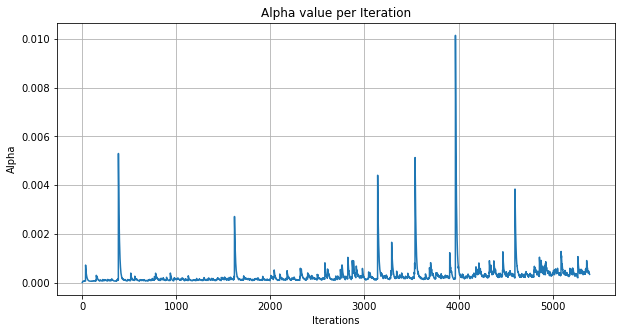

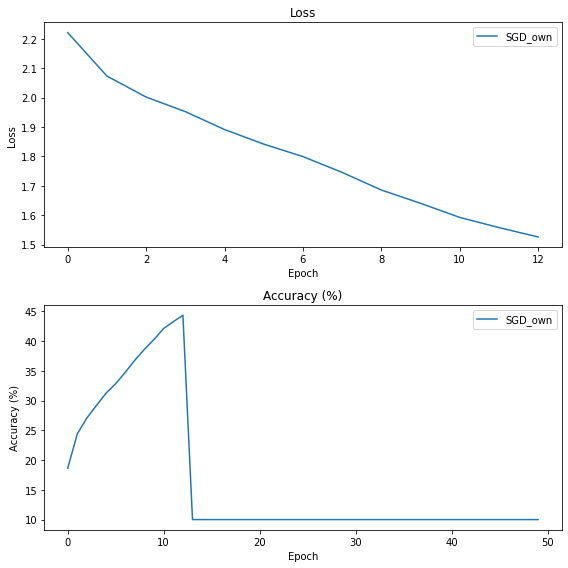

In [5]:
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torchvision.transforms as transforms
from torchvision import datasets
import copy
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt

gamma = 0.9

def compute_step_size(X, W, gradient, Y_hot):
    global past_10th_epoch

    if past_10th_epoch:
        return compute_step_size.avg_step_size * 10 ###############################

    W = W.t()
    gradient = gradient.t()
    term1 = torch.sum(torch.exp(-torch.mm(X, W)), dim=1)
    term2 = torch.sum(torch.mm(X, gradient), dim=1)
    term3 = torch.exp(-torch.sum(X * (torch.mm(Y_hot, torch.transpose(W, 0, 1))), dim=1))
    term4 = torch.sum(X * (torch.mm(Y_hot, torch.transpose(gradient, 0, 1))), dim=1)
    
    a = ((term1 * (term2**2)) - (term3 * (term4**2))) / 2
    b = (term1 * term2) - (term3 * term4)
    c = (term1 - term3) - ((term2 * term1 / term4) - (term3))

    alpha = torch.mean(torch.abs((-b + torch.sqrt(b**2 - 4*a*c)) / (2*a))) * 0.00002
    
    alpha = torch.clamp(alpha, 0.00005, 0.1)          #############################
    
    if not hasattr(compute_step_size, "avg_step_size"):
        compute_step_size.avg_step_size = 0
        
    compute_step_size.avg_step_size = gamma * compute_step_size.avg_step_size + (1 - gamma) * alpha.item()
    
    return compute_step_size.avg_step_size

class SGD_own(Optimizer):
    def __init__(self, params, lr=1e-2):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SGD_own, self).__init__(params, defaults)
        self.alphas = [] 

    def step(self, X, W, gradient, Y_hot, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        lr_last_layer = compute_step_size(X, W, gradient, Y_hot)
        lr_first_layer = lr_last_layer * 1  # Scaling first layer #################
        
        self.alphas.append(lr_last_layer)
        
        num_layers = len(self.param_groups[0]['params'])
        
        for group in self.param_groups:
            for idx, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                # Linear interpolation of the learning rate based on the layer index
                lr_scale = idx / (num_layers - 1)
                lr_current_layer = lr_first_layer + lr_scale * (lr_last_layer - lr_first_layer)
                
                p.data.add_(d_p, alpha=-lr_current_layer)
        
        return loss


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ResNet18Wrapper(nn.Module):
    def __init__(self):
        super(ResNet18Wrapper, self).__init__()
        self.resnet = resnet18(weights=None)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 10)  # 10 classes CIFAR10

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        
        self.features_before_fc = x
        x = self.resnet.fc(self.features_before_fc)
        return F.log_softmax(x, dim=1)
    

def evaluate_model(model, loader, criterion):
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        avg_loss = running_loss / len(loader)
        avg_accuracy = correct / total * 100
    return avg_loss, avg_accuracy



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

model = ResNet18Wrapper().to(device)
original_model_state = copy.deepcopy(model.state_dict())

criterion = nn.CrossEntropyLoss()
initial_loss, initial_accuracy = evaluate_model(model, trainloader, criterion)

optimizers = {'SGD_own': SGD_own(model.parameters(), lr=0.01),
}


history = {}

for name, optimizer in optimizers.items():
    print(f'---- {name} ----')
    model.load_state_dict(copy.deepcopy(original_model_state))

    epoch_losses = []
    epoch_accuracies = []
    time_points = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    
    start_time = time.time()
    epoch_losses.append(initial_loss)
    epoch_accuracies.append(initial_accuracy)
    time_points.append(0)
    
    past_10th_epoch = False

            
    for epoch in range(50):
        if epoch == 40: ##################################################################################
            past_10th_epoch = True
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            X = model.features_before_fc
            W = model.resnet.fc.weight.data  # This is the last layer's weight
            gradient = model.resnet.fc.weight.grad.data
            Y_hot = F.one_hot(labels, num_classes=10).float()

            optimizer.step(X, W, gradient, Y_hot)
            
            

        test_epoch_loss, test_epoch_accuracy = evaluate_model(model, testloader, criterion)
        test_epoch_losses.append(test_epoch_loss)
        test_epoch_accuracies.append(test_epoch_accuracy)
        print(f'Test Epoch {epoch + 1}, loss: {test_epoch_loss}, accuracy: {test_epoch_accuracy}%')
        
    print('Training finished. Time elapsed: ', time.time() - start_time)
    
    history[name] = {'train_loss': epoch_losses, 
                     'train_accuracy': epoch_accuracies, 
                     'test_loss': test_epoch_losses, 
                     'test_accuracy': test_epoch_accuracies, 
                     'time': time_points}

    
plt.figure(figsize=(10, 5))
plt.plot(optimizers['SGD_own'].alphas)
plt.xlabel('Iterations')
plt.ylabel('Alpha')
plt.title('Alpha value per Iteration')
plt.grid(True)
plt.show()


fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 8))

for name, hist in history.items():
    ax1.plot(hist['test_loss'], label=name)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(hist['test_accuracy'], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy (%)')
    ax2.legend()


plt.tight_layout()
plt.show()

In [6]:
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torchvision.transforms as transforms
from torchvision import datasets
import copy
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt

gamma = 0.9

def compute_step_size(X, W, gradient, Y_hot):
    global past_10th_epoch

    if past_10th_epoch:
        return compute_step_size.avg_step_size * 10 ###############################

    W = W.t()
    gradient = gradient.t()
    term1 = torch.sum(torch.exp(-torch.mm(X, W)), dim=1)
    term2 = torch.sum(torch.mm(X, gradient), dim=1)
    term3 = torch.exp(-torch.sum(X * (torch.mm(Y_hot, torch.transpose(W, 0, 1))), dim=1))
    term4 = torch.sum(X * (torch.mm(Y_hot, torch.transpose(gradient, 0, 1))), dim=1)
    
    a = ((term1 * (term2**2)) - (term3 * (term4**2))) / 2
    b = (term1 * term2) - (term3 * term4)
    c = (term1 - term3) - ((term2 * term1 / term4) - (term3))

    alpha = torch.mean(torch.abs((-b + torch.sqrt(b**2 - 4*a*c)) / (2*a))) * 0.00002
    
    alpha = torch.clamp(alpha, 0.00005, 0.1)          #############################
    
    if not hasattr(compute_step_size, "avg_step_size"):
        compute_step_size.avg_step_size = 0
        
    compute_step_size.avg_step_size = gamma * compute_step_size.avg_step_size + (1 - gamma) * alpha.item()
    
    return compute_step_size.avg_step_size

class SGD_own(Optimizer):
    def __init__(self, params, lr=1e-2):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SGD_own, self).__init__(params, defaults)
        self.alphas = [] 

    def step(self, X, W, gradient, Y_hot, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        lr_last_layer = compute_step_size(X, W, gradient, Y_hot)
        lr_first_layer = lr_last_layer * 1  # Scaling first layer #################
        
        self.alphas.append(lr_last_layer)
        
        num_layers = len(self.param_groups[0]['params'])
        
        for group in self.param_groups:
            for idx, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                # Linear interpolation of the learning rate based on the layer index
                lr_scale = idx / (num_layers - 1)
                lr_current_layer = lr_first_layer + lr_scale * (lr_last_layer - lr_first_layer)
                
                p.data.add_(d_p, alpha=-lr_current_layer)
        
        return loss


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ResNet18Wrapper(nn.Module):
    def __init__(self):
        super(ResNet18Wrapper, self).__init__()
        self.resnet = resnet18(weights=None)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 10)  # 10 classes CIFAR10

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        
        self.features_before_fc = x
        x = self.resnet.fc(self.features_before_fc)
        return F.log_softmax(x, dim=1)
    

def evaluate_model(model, loader, criterion):
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        avg_loss = running_loss / len(loader)
        avg_accuracy = correct / total * 100
    return avg_loss, avg_accuracy



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

model = ResNet18Wrapper().to(device)
original_model_state = copy.deepcopy(model.state_dict())

criterion = nn.CrossEntropyLoss()
initial_loss, initial_accuracy = evaluate_model(model, trainloader, criterion)

optimizers = {'SGD_own': SGD_own(model.parameters(), lr=0.01),
}


history = {}

for name, optimizer in optimizers.items():
    print(f'---- {name} ----')
    model.load_state_dict(copy.deepcopy(original_model_state))

    epoch_losses = []
    epoch_accuracies = []
    time_points = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    
    start_time = time.time()
    epoch_losses.append(initial_loss)
    epoch_accuracies.append(initial_accuracy)
    time_points.append(0)
    
    past_10th_epoch = False

            
    for epoch in range(50):
        if epoch == 40: ##################################################################################
            past_10th_epoch = True
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            X = model.features_before_fc
            W = model.resnet.fc.weight.data  # This is the last layer's weight
            gradient = model.resnet.fc.weight.grad.data
            Y_hot = F.one_hot(labels, num_classes=10).float()

            optimizer.step(X, W, gradient, Y_hot)
            
            

        test_epoch_loss, test_epoch_accuracy = evaluate_model(model, testloader, criterion)
        test_epoch_losses.append(test_epoch_loss)
        test_epoch_accuracies.append(test_epoch_accuracy)
        print(f'Test Epoch {epoch + 1}, loss: {test_epoch_loss}, accuracy: {test_epoch_accuracy}%')
        
    print('Training finished. Time elapsed: ', time.time() - start_time)
    
    history[name] = {'train_loss': epoch_losses, 
                     'train_accuracy': epoch_accuracies, 
                     'test_loss': test_epoch_losses, 
                     'test_accuracy': test_epoch_accuracies, 
                     'time': time_points}

    
plt.figure(figsize=(10, 5))
plt.plot(optimizers['SGD_own'].alphas)
plt.xlabel('Iterations')
plt.ylabel('Alpha')
plt.title('Alpha value per Iteration')
plt.grid(True)
plt.show()


fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 8))

for name, hist in history.items():
    ax1.plot(hist['test_loss'], label=name)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(hist['test_accuracy'], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy (%)')
    ax2.legend()


plt.tight_layout()
plt.show()

Files already downloaded and verified
Files already downloaded and verified
---- SGD_own ----
Test Epoch 1, loss: 2.3225156687483004, accuracy: 15.18%
Test Epoch 2, loss: 2.209786061999164, accuracy: 19.45%
Test Epoch 3, loss: 2.0174734169923805, accuracy: 26.43%
Test Epoch 4, loss: 1.9057580760762662, accuracy: 31.0%
Test Epoch 5, loss: 1.8395425699934174, accuracy: 33.019999999999996%
Test Epoch 6, loss: 1.7617830958547471, accuracy: 36.059999999999995%
Test Epoch 7, loss: nan, accuracy: 10.0%
Test Epoch 8, loss: nan, accuracy: 10.0%


KeyboardInterrupt: 

In [7]:
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torchvision.transforms as transforms
from torchvision import datasets
import copy
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt

gamma = 0.9

def compute_step_size(X, W, gradient, Y_hot):
    global past_10th_epoch

    if past_10th_epoch:
        return compute_step_size.avg_step_size * 10 ###############################

    W = W.t()
    gradient = gradient.t()
    term1 = torch.sum(torch.exp(-torch.mm(X, W)), dim=1)
    term2 = torch.sum(torch.mm(X, gradient), dim=1)
    term3 = torch.exp(-torch.sum(X * (torch.mm(Y_hot, torch.transpose(W, 0, 1))), dim=1))
    term4 = torch.sum(X * (torch.mm(Y_hot, torch.transpose(gradient, 0, 1))), dim=1)
    
    a = ((term1 * (term2**2)) - (term3 * (term4**2))) / 2
    b = (term1 * term2) - (term3 * term4)
    c = (term1 - term3) - ((term2 * term1 / term4) - (term3))

    alpha = torch.mean(torch.abs((-b + torch.sqrt(b**2 - 4*a*c)) / (2*a))) * 0.00002
    
    alpha = torch.clamp(alpha, 0.00005, 0.1)          #############################
    
    if not hasattr(compute_step_size, "avg_step_size"):
        compute_step_size.avg_step_size = 0
        
    compute_step_size.avg_step_size = gamma * compute_step_size.avg_step_size + (1 - gamma) * alpha.item()
    
    return compute_step_size.avg_step_size

class SGD_own(Optimizer):
    def __init__(self, params, lr=1e-2):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SGD_own, self).__init__(params, defaults)
        self.alphas = [] 

    def step(self, X, W, gradient, Y_hot, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        lr_last_layer = compute_step_size(X, W, gradient, Y_hot)
        lr_first_layer = lr_last_layer * 1  # Scaling first layer #################
        
        self.alphas.append(lr_last_layer)
        
        num_layers = len(self.param_groups[0]['params'])
        
        for group in self.param_groups:
            for idx, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                # Linear interpolation of the learning rate based on the layer index
                lr_scale = idx / (num_layers - 1)
                lr_current_layer = lr_first_layer + lr_scale * (lr_last_layer - lr_first_layer)
                
                p.data.add_(d_p, alpha=-lr_current_layer)
        
        return loss


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ResNet18Wrapper(nn.Module):
    def __init__(self):
        super(ResNet18Wrapper, self).__init__()
        self.resnet = resnet18(weights=None)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 10)  # 10 classes CIFAR10

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        
        self.features_before_fc = x
        x = self.resnet.fc(self.features_before_fc)
        return F.log_softmax(x, dim=1)
    

def evaluate_model(model, loader, criterion):
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        avg_loss = running_loss / len(loader)
        avg_accuracy = correct / total * 100
    return avg_loss, avg_accuracy



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

model = ResNet18Wrapper().to(device)
original_model_state = copy.deepcopy(model.state_dict())

criterion = nn.CrossEntropyLoss()
initial_loss, initial_accuracy = evaluate_model(model, trainloader, criterion)

optimizers = {'SGD_own': SGD_own(model.parameters(), lr=0.01),
}


history = {}

for name, optimizer in optimizers.items():
    print(f'---- {name} ----')
    model.load_state_dict(copy.deepcopy(original_model_state))

    epoch_losses = []
    epoch_accuracies = []
    time_points = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    
    start_time = time.time()
    epoch_losses.append(initial_loss)
    epoch_accuracies.append(initial_accuracy)
    time_points.append(0)
    
    past_10th_epoch = False

            
    for epoch in range(50):
        if epoch == 40: ##################################################################################
            past_10th_epoch = True
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            X = model.features_before_fc
            W = model.resnet.fc.weight.data  # This is the last layer's weight
            gradient = model.resnet.fc.weight.grad.data
            Y_hot = F.one_hot(labels, num_classes=10).float()

            optimizer.step(X, W, gradient, Y_hot)
            
            

        test_epoch_loss, test_epoch_accuracy = evaluate_model(model, testloader, criterion)
        test_epoch_losses.append(test_epoch_loss)
        test_epoch_accuracies.append(test_epoch_accuracy)
        print(f'Test Epoch {epoch + 1}, loss: {test_epoch_loss}, accuracy: {test_epoch_accuracy}%')
        
    print('Training finished. Time elapsed: ', time.time() - start_time)
    
    history[name] = {'train_loss': epoch_losses, 
                     'train_accuracy': epoch_accuracies, 
                     'test_loss': test_epoch_losses, 
                     'test_accuracy': test_epoch_accuracies, 
                     'time': time_points}

    
plt.figure(figsize=(10, 5))
plt.plot(optimizers['SGD_own'].alphas)
plt.xlabel('Iterations')
plt.ylabel('Alpha')
plt.title('Alpha value per Iteration')
plt.grid(True)
plt.show()


fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 8))

for name, hist in history.items():
    ax1.plot(hist['test_loss'], label=name)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(hist['test_accuracy'], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy (%)')
    ax2.legend()


plt.tight_layout()
plt.show()

Files already downloaded and verified
Files already downloaded and verified
---- SGD_own ----
Test Epoch 1, loss: 2.322806693330596, accuracy: 15.39%
Test Epoch 2, loss: 2.186183724222304, accuracy: 21.14%
Test Epoch 3, loss: 2.0947532533090327, accuracy: 24.64%
Test Epoch 4, loss: 1.9831882609596736, accuracy: 28.33%
Test Epoch 5, loss: 1.9238954359972025, accuracy: 30.53%
Test Epoch 6, loss: 1.8896711521510836, accuracy: 31.230000000000004%
Test Epoch 7, loss: 1.8321607776834994, accuracy: 33.36%
Test Epoch 8, loss: 1.7931130370007287, accuracy: 35.089999999999996%
Test Epoch 9, loss: 1.735740082173408, accuracy: 36.84%
Test Epoch 10, loss: 1.7006635409367235, accuracy: 38.32%
Test Epoch 11, loss: 1.668937987919095, accuracy: 38.93%
Test Epoch 12, loss: 1.6319103422044199, accuracy: 40.48%
Test Epoch 13, loss: 1.608156681060791, accuracy: 41.47%
Test Epoch 14, loss: 1.56357790699488, accuracy: 42.64%
Test Epoch 15, loss: 1.5273273006270203, accuracy: 43.9%
Test Epoch 16, loss: 1.4991

KeyboardInterrupt: 

In [8]:
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torchvision.transforms as transforms
from torchvision import datasets
import copy
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt

gamma = 0.9

def compute_step_size(X, W, gradient, Y_hot):
    global past_10th_epoch

    if past_10th_epoch:
        return compute_step_size.avg_step_size * 10 ###############################

    W = W.t()
    gradient = gradient.t()
    term1 = torch.sum(torch.exp(-torch.mm(X, W)), dim=1)
    term2 = torch.sum(torch.mm(X, gradient), dim=1)
    term3 = torch.exp(-torch.sum(X * (torch.mm(Y_hot, torch.transpose(W, 0, 1))), dim=1))
    term4 = torch.sum(X * (torch.mm(Y_hot, torch.transpose(gradient, 0, 1))), dim=1)
    
    a = ((term1 * (term2**2)) - (term3 * (term4**2))) / 2
    b = (term1 * term2) - (term3 * term4)
    c = (term1 - term3) - ((term2 * term1 / term4) - (term3))

    alpha = torch.mean(torch.abs((-b + torch.sqrt(b**2 - 4*a*c)) / (2*a))) * 0.00002
    
    alpha = torch.clamp(alpha, 0.00005, 0.1)          #############################
    
    if not hasattr(compute_step_size, "avg_step_size"):
        compute_step_size.avg_step_size = 0
        
    compute_step_size.avg_step_size = gamma * compute_step_size.avg_step_size + (1 - gamma) * alpha.item()
    
    return compute_step_size.avg_step_size

class SGD_own(Optimizer):
    def __init__(self, params, lr=1e-2):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SGD_own, self).__init__(params, defaults)
        self.alphas = [] 

    def step(self, X, W, gradient, Y_hot, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        lr_last_layer = compute_step_size(X, W, gradient, Y_hot)
        lr_first_layer = lr_last_layer * 1  # Scaling first layer #################
        
        self.alphas.append(lr_last_layer)
        
        num_layers = len(self.param_groups[0]['params'])
        
        for group in self.param_groups:
            for idx, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                # Linear interpolation of the learning rate based on the layer index
                lr_scale = idx / (num_layers - 1)
                lr_current_layer = lr_first_layer + lr_scale * (lr_last_layer - lr_first_layer)
                
                p.data.add_(d_p, alpha=-lr_current_layer)
        
        return loss


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ResNet18Wrapper(nn.Module):
    def __init__(self):
        super(ResNet18Wrapper, self).__init__()
        self.resnet = resnet18(weights=None)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 10)  # 10 classes CIFAR10

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        
        self.features_before_fc = x
        x = self.resnet.fc(self.features_before_fc)
        return F.log_softmax(x, dim=1)
    

def evaluate_model(model, loader, criterion):
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        avg_loss = running_loss / len(loader)
        avg_accuracy = correct / total * 100
    return avg_loss, avg_accuracy



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

model = ResNet18Wrapper().to(device)
original_model_state = copy.deepcopy(model.state_dict())

criterion = nn.CrossEntropyLoss()
initial_loss, initial_accuracy = evaluate_model(model, trainloader, criterion)

optimizers = {'SGD_own': SGD_own(model.parameters(), lr=0.01),
}


history = {}

for name, optimizer in optimizers.items():
    print(f'---- {name} ----')
    model.load_state_dict(copy.deepcopy(original_model_state))

    epoch_losses = []
    epoch_accuracies = []
    time_points = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    
    start_time = time.time()
    epoch_losses.append(initial_loss)
    epoch_accuracies.append(initial_accuracy)
    time_points.append(0)
    
    past_10th_epoch = False

            
    for epoch in range(50):
        if epoch == 40: ##################################################################################
            past_10th_epoch = True
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            X = model.features_before_fc
            W = model.resnet.fc.weight.data  # This is the last layer's weight
            gradient = model.resnet.fc.weight.grad.data
            Y_hot = F.one_hot(labels, num_classes=10).float()

            optimizer.step(X, W, gradient, Y_hot)
            
            

        test_epoch_loss, test_epoch_accuracy = evaluate_model(model, testloader, criterion)
        test_epoch_losses.append(test_epoch_loss)
        test_epoch_accuracies.append(test_epoch_accuracy)
        print(f'Test Epoch {epoch + 1}, loss: {test_epoch_loss}, accuracy: {test_epoch_accuracy}%')
        
    print('Training finished. Time elapsed: ', time.time() - start_time)
    
    history[name] = {'train_loss': epoch_losses, 
                     'train_accuracy': epoch_accuracies, 
                     'test_loss': test_epoch_losses, 
                     'test_accuracy': test_epoch_accuracies, 
                     'time': time_points}

    
plt.figure(figsize=(10, 5))
plt.plot(optimizers['SGD_own'].alphas)
plt.xlabel('Iterations')
plt.ylabel('Alpha')
plt.title('Alpha value per Iteration')
plt.grid(True)
plt.show()


fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 8))

for name, hist in history.items():
    ax1.plot(hist['test_loss'], label=name)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(hist['test_accuracy'], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy (%)')
    ax2.legend()


plt.tight_layout()
plt.show()

Files already downloaded and verified
Files already downloaded and verified
---- SGD_own ----
Test Epoch 1, loss: 2.2511592786523362, accuracy: 17.14%
Test Epoch 2, loss: 2.077842925168291, accuracy: 24.91%
Test Epoch 3, loss: 2.00138648250435, accuracy: 27.500000000000004%
Test Epoch 4, loss: 1.9268201981918722, accuracy: 30.470000000000002%
Test Epoch 5, loss: 1.870808278458028, accuracy: 32.4%
Test Epoch 6, loss: 1.7870935790146454, accuracy: 35.38%
Test Epoch 7, loss: 1.7297502771208557, accuracy: 36.77%
Test Epoch 8, loss: 1.690725261652017, accuracy: 38.190000000000005%
Test Epoch 9, loss: 1.6483405315423314, accuracy: 40.089999999999996%
Test Epoch 10, loss: 1.5947138176688664, accuracy: 41.81%
Test Epoch 11, loss: 1.5405967401552805, accuracy: 43.14%
Test Epoch 12, loss: 1.513637035707884, accuracy: 44.5%
Test Epoch 13, loss: 1.483584770673438, accuracy: 45.65%
Test Epoch 14, loss: 1.457558188257338, accuracy: 46.56%
Test Epoch 15, loss: 1.4355587446236913, accuracy: 47.58%
Tes

KeyboardInterrupt: 

# CON 0.01 LAYER SCALING 

In [9]:
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torchvision.transforms as transforms
from torchvision import datasets
import copy
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt

gamma = 0.9

def compute_step_size(X, W, gradient, Y_hot):
    global past_10th_epoch

    if past_10th_epoch:
        return compute_step_size.avg_step_size * 10 ###############################

    W = W.t()
    gradient = gradient.t()
    term1 = torch.sum(torch.exp(-torch.mm(X, W)), dim=1)
    term2 = torch.sum(torch.mm(X, gradient), dim=1)
    term3 = torch.exp(-torch.sum(X * (torch.mm(Y_hot, torch.transpose(W, 0, 1))), dim=1))
    term4 = torch.sum(X * (torch.mm(Y_hot, torch.transpose(gradient, 0, 1))), dim=1)
    
    a = ((term1 * (term2**2)) - (term3 * (term4**2))) / 2
    b = (term1 * term2) - (term3 * term4)
    c = (term1 - term3) - ((term2 * term1 / term4) - (term3))

    alpha = torch.mean(torch.abs((-b + torch.sqrt(b**2 - 4*a*c)) / (2*a))) * 0.00002
    
    alpha = torch.clamp(alpha, 0.00005, 0.1)          #############################
    
    if not hasattr(compute_step_size, "avg_step_size"):
        compute_step_size.avg_step_size = 0
        
    compute_step_size.avg_step_size = gamma * compute_step_size.avg_step_size + (1 - gamma) * alpha.item()
    
    return compute_step_size.avg_step_size

class SGD_own(Optimizer):
    def __init__(self, params, lr=1e-2):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SGD_own, self).__init__(params, defaults)
        self.alphas = [] 

    def step(self, X, W, gradient, Y_hot, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        lr_last_layer = compute_step_size(X, W, gradient, Y_hot)
        lr_first_layer = lr_last_layer * 0.01  # Scaling first layer #################
        
        self.alphas.append(lr_last_layer)
        
        num_layers = len(self.param_groups[0]['params'])
        
        for group in self.param_groups:
            for idx, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                # Linear interpolation of the learning rate based on the layer index
                lr_scale = idx / (num_layers - 1)
                lr_current_layer = lr_first_layer + lr_scale * (lr_last_layer - lr_first_layer)
                
                p.data.add_(d_p, alpha=-lr_current_layer)
        
        return loss


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ResNet18Wrapper(nn.Module):
    def __init__(self):
        super(ResNet18Wrapper, self).__init__()
        self.resnet = resnet18(weights=None)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 10)  # 10 classes CIFAR10

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        
        self.features_before_fc = x
        x = self.resnet.fc(self.features_before_fc)
        return F.log_softmax(x, dim=1)
    

def evaluate_model(model, loader, criterion):
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        avg_loss = running_loss / len(loader)
        avg_accuracy = correct / total * 100
    return avg_loss, avg_accuracy



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

model = ResNet18Wrapper().to(device)
original_model_state = copy.deepcopy(model.state_dict())

criterion = nn.CrossEntropyLoss()
initial_loss, initial_accuracy = evaluate_model(model, trainloader, criterion)

optimizers = {'SGD_own': SGD_own(model.parameters(), lr=0.01),
}


history = {}

for name, optimizer in optimizers.items():
    print(f'---- {name} ----')
    model.load_state_dict(copy.deepcopy(original_model_state))

    epoch_losses = []
    epoch_accuracies = []
    time_points = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    
    start_time = time.time()
    epoch_losses.append(initial_loss)
    epoch_accuracies.append(initial_accuracy)
    time_points.append(0)
    
    past_10th_epoch = False

            
    for epoch in range(50):
        if epoch == 40: ##################################################################################
            past_10th_epoch = True
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            X = model.features_before_fc
            W = model.resnet.fc.weight.data  # This is the last layer's weight
            gradient = model.resnet.fc.weight.grad.data
            Y_hot = F.one_hot(labels, num_classes=10).float()

            optimizer.step(X, W, gradient, Y_hot)
            
            

        test_epoch_loss, test_epoch_accuracy = evaluate_model(model, testloader, criterion)
        test_epoch_losses.append(test_epoch_loss)
        test_epoch_accuracies.append(test_epoch_accuracy)
        print(f'Test Epoch {epoch + 1}, loss: {test_epoch_loss}, accuracy: {test_epoch_accuracy}%')
        
    print('Training finished. Time elapsed: ', time.time() - start_time)
    
    history[name] = {'train_loss': epoch_losses, 
                     'train_accuracy': epoch_accuracies, 
                     'test_loss': test_epoch_losses, 
                     'test_accuracy': test_epoch_accuracies, 
                     'time': time_points}

    
plt.figure(figsize=(10, 5))
plt.plot(optimizers['SGD_own'].alphas)
plt.xlabel('Iterations')
plt.ylabel('Alpha')
plt.title('Alpha value per Iteration')
plt.grid(True)
plt.show()


fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 8))

for name, hist in history.items():
    ax1.plot(hist['test_loss'], label=name)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(hist['test_accuracy'], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy (%)')
    ax2.legend()


plt.tight_layout()
plt.show()

Files already downloaded and verified
Files already downloaded and verified
---- SGD_own ----
Test Epoch 1, loss: 2.350490126428725, accuracy: 12.67%
Test Epoch 2, loss: 2.1870457613015475, accuracy: 19.580000000000002%
Test Epoch 3, loss: 2.136699063868462, accuracy: 21.66%
Test Epoch 4, loss: 2.0970830223228356, accuracy: 23.200000000000003%
Test Epoch 5, loss: 2.043167821968658, accuracy: 25.290000000000003%
Test Epoch 6, loss: 2.0209738649899447, accuracy: 26.36%
Test Epoch 7, loss: 1.987022475351261, accuracy: 27.6%
Test Epoch 8, loss: nan, accuracy: 10.0%
Test Epoch 9, loss: nan, accuracy: 10.0%
Test Epoch 10, loss: nan, accuracy: 10.0%
Test Epoch 11, loss: nan, accuracy: 10.0%
Test Epoch 12, loss: nan, accuracy: 10.0%
Test Epoch 13, loss: nan, accuracy: 10.0%


KeyboardInterrupt: 

In [11]:
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torchvision.transforms as transforms
from torchvision import datasets
import copy
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt

gamma = 0.9

def compute_step_size(X, W, gradient, Y_hot):
    global past_10th_epoch

    if past_10th_epoch:
        return compute_step_size.avg_step_size * 10 ###############################

    W = W.t()
    gradient = gradient.t()
    term1 = torch.sum(torch.exp(-torch.mm(X, W)), dim=1)
    term2 = torch.sum(torch.mm(X, gradient), dim=1)
    term3 = torch.exp(-torch.sum(X * (torch.mm(Y_hot, torch.transpose(W, 0, 1))), dim=1))
    term4 = torch.sum(X * (torch.mm(Y_hot, torch.transpose(gradient, 0, 1))), dim=1)
    
    a = ((term1 * (term2**2)) - (term3 * (term4**2))) / 2
    b = (term1 * term2) - (term3 * term4)
    c = (term1 - term3) - ((term2 * term1 / term4) - (term3))

    alpha = torch.mean(torch.abs((-b + torch.sqrt(b**2 - 4*a*c)) / (2*a))) * 0.00002
    
    alpha = torch.clamp(alpha, 0.00005, 0.1)          #############################
    
    if not hasattr(compute_step_size, "avg_step_size"):
        compute_step_size.avg_step_size = 0
        
    compute_step_size.avg_step_size = gamma * compute_step_size.avg_step_size + (1 - gamma) * alpha.item()
    
    return compute_step_size.avg_step_size

class SGD_own(Optimizer):
    def __init__(self, params, lr=1e-2):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SGD_own, self).__init__(params, defaults)
        self.alphas = [] 

    def step(self, X, W, gradient, Y_hot, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        lr_last_layer = compute_step_size(X, W, gradient, Y_hot)
        lr_first_layer = lr_last_layer * 0.01  # Scaling first layer #################
        
        self.alphas.append(lr_last_layer)
        
        num_layers = len(self.param_groups[0]['params'])
        
        for group in self.param_groups:
            for idx, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                # Linear interpolation of the learning rate based on the layer index
                lr_scale = idx / (num_layers - 1)
                lr_current_layer = lr_first_layer + lr_scale * (lr_last_layer - lr_first_layer)
                
                p.data.add_(d_p, alpha=-lr_current_layer)
        
        return loss


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ResNet18Wrapper(nn.Module):
    def __init__(self):
        super(ResNet18Wrapper, self).__init__()
        self.resnet = resnet18(weights=None)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 10)  # 10 classes CIFAR10

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        
        self.features_before_fc = x
        x = self.resnet.fc(self.features_before_fc)
        return F.log_softmax(x, dim=1)
    

def evaluate_model(model, loader, criterion):
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        avg_loss = running_loss / len(loader)
        avg_accuracy = correct / total * 100
    return avg_loss, avg_accuracy



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

model = ResNet18Wrapper().to(device)
original_model_state = copy.deepcopy(model.state_dict())

criterion = nn.CrossEntropyLoss()
initial_loss, initial_accuracy = evaluate_model(model, trainloader, criterion)

optimizers = {'SGD_own': SGD_own(model.parameters(), lr=0.01),
}


history = {}

for name, optimizer in optimizers.items():
    print(f'---- {name} ----')
    model.load_state_dict(copy.deepcopy(original_model_state))

    epoch_losses = []
    epoch_accuracies = []
    time_points = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    
    start_time = time.time()
    epoch_losses.append(initial_loss)
    epoch_accuracies.append(initial_accuracy)
    time_points.append(0)
    
    past_10th_epoch = False

            
    for epoch in range(50):
        if epoch == 40: ##################################################################################
            past_10th_epoch = True
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            X = model.features_before_fc
            W = model.resnet.fc.weight.data  # This is the last layer's weight
            gradient = model.resnet.fc.weight.grad.data
            Y_hot = F.one_hot(labels, num_classes=10).float()

            optimizer.step(X, W, gradient, Y_hot)
            
            

        test_epoch_loss, test_epoch_accuracy = evaluate_model(model, testloader, criterion)
        test_epoch_losses.append(test_epoch_loss)
        test_epoch_accuracies.append(test_epoch_accuracy)
        print(f'Test Epoch {epoch + 1}, loss: {test_epoch_loss}, accuracy: {test_epoch_accuracy}%')
        
    print('Training finished. Time elapsed: ', time.time() - start_time)
    
    history[name] = {'train_loss': epoch_losses, 
                     'train_accuracy': epoch_accuracies, 
                     'test_loss': test_epoch_losses, 
                     'test_accuracy': test_epoch_accuracies, 
                     'time': time_points}

    
plt.figure(figsize=(10, 5))
plt.plot(optimizers['SGD_own'].alphas)
plt.xlabel('Iterations')
plt.ylabel('Alpha')
plt.title('Alpha value per Iteration')
plt.grid(True)
plt.show()


fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 8))

for name, hist in history.items():
    ax1.plot(hist['test_loss'], label=name)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(hist['test_accuracy'], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy (%)')
    ax2.legend()


plt.tight_layout()
plt.show()

Files already downloaded and verified
Files already downloaded and verified
---- SGD_own ----
Test Epoch 1, loss: nan, accuracy: 10.0%
Test Epoch 2, loss: nan, accuracy: 10.0%
Test Epoch 3, loss: nan, accuracy: 10.0%
Test Epoch 4, loss: nan, accuracy: 10.0%
Test Epoch 5, loss: nan, accuracy: 10.0%


KeyboardInterrupt: 

# CON 0.01 LAYER SCALING  CLIPPING 0.02 BETA 0.99

Files already downloaded and verified
Files already downloaded and verified
---- SGD_own ----
Test Epoch 1, loss: 2.200491123561618, accuracy: 19.439999999999998%
Test Epoch 2, loss: 2.0104675745662255, accuracy: 27.310000000000002%
Test Epoch 3, loss: 1.909161848357961, accuracy: 31.28%
Test Epoch 4, loss: 1.8211997928498667, accuracy: 34.44%
Test Epoch 5, loss: 1.7558735503426082, accuracy: 37.11%
Test Epoch 6, loss: 1.692048347449001, accuracy: 39.51%
Test Epoch 7, loss: 1.6428842378568045, accuracy: 41.27%
Test Epoch 8, loss: 1.607452012315581, accuracy: 42.870000000000005%
Test Epoch 9, loss: 1.5760562721687028, accuracy: 43.64%
Test Epoch 10, loss: 1.5471891858909703, accuracy: 44.91%
Test Epoch 11, loss: nan, accuracy: 10.0%
Test Epoch 12, loss: nan, accuracy: 10.0%
Test Epoch 13, loss: nan, accuracy: 10.0%
Test Epoch 14, loss: nan, accuracy: 10.0%
Test Epoch 15, loss: nan, accuracy: 10.0%
Test Epoch 16, loss: nan, accuracy: 10.0%
Test Epoch 17, loss: nan, accuracy: 10.0%
Test E

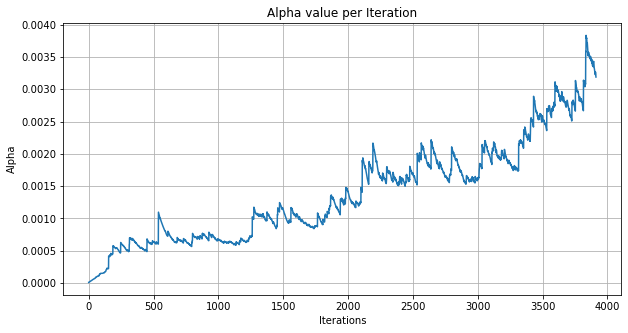

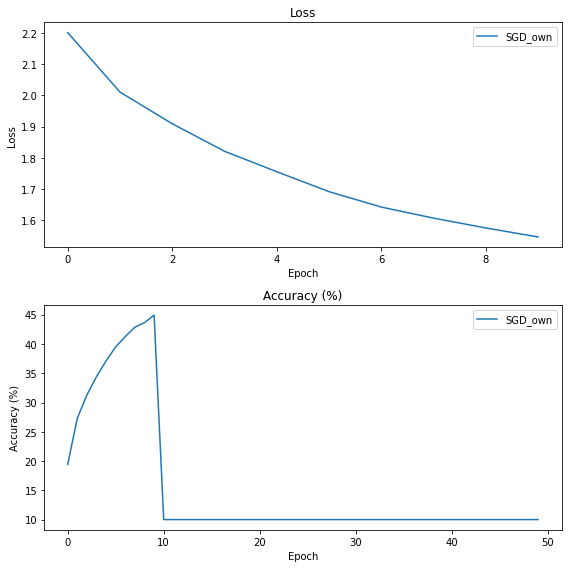

In [14]:
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torchvision.transforms as transforms
from torchvision import datasets
import copy
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt

gamma = 0.99

def compute_step_size(X, W, gradient, Y_hot):
    global past_10th_epoch

    if past_10th_epoch:
        return compute_step_size.avg_step_size * 10 ###############################

    W = W.t()
    gradient = gradient.t()
    term1 = torch.sum(torch.exp(-torch.mm(X, W)), dim=1)
    term2 = torch.sum(torch.mm(X, gradient), dim=1)
    term3 = torch.exp(-torch.sum(X * (torch.mm(Y_hot, torch.transpose(W, 0, 1))), dim=1))
    term4 = torch.sum(X * (torch.mm(Y_hot, torch.transpose(gradient, 0, 1))), dim=1)
    
    a = ((term1 * (term2**2)) - (term3 * (term4**2))) / 2
    b = (term1 * term2) - (term3 * term4)
    c = (term1 - term3) - ((term2 * term1 / term4) - (term3))

    alpha = torch.mean(torch.abs((-b + torch.sqrt(b**2 - 4*a*c)) / (2*a))) * 0.0001
    
    alpha = torch.clamp(alpha, 0.00005, 0.05)          #############################
    
    if not hasattr(compute_step_size, "avg_step_size"):
        compute_step_size.avg_step_size = 0
        
    compute_step_size.avg_step_size = gamma * compute_step_size.avg_step_size + (1 - gamma) * alpha.item()
    
    return compute_step_size.avg_step_size

class SGD_own(Optimizer):
    def __init__(self, params, lr=1e-2):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SGD_own, self).__init__(params, defaults)
        self.alphas = [] 

    def step(self, X, W, gradient, Y_hot, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        lr_last_layer = compute_step_size(X, W, gradient, Y_hot)
        lr_first_layer = lr_last_layer * 0.01  # Scaling first layer #################
        
        self.alphas.append(lr_last_layer)
        
        num_layers = len(self.param_groups[0]['params'])
        
        for group in self.param_groups:
            for idx, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                # Linear interpolation of the learning rate based on the layer index
                lr_scale = idx / (num_layers - 1)
                lr_current_layer = lr_first_layer + lr_scale * (lr_last_layer - lr_first_layer)
                
                p.data.add_(d_p, alpha=-lr_current_layer)
        
        return loss


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ResNet18Wrapper(nn.Module):
    def __init__(self):
        super(ResNet18Wrapper, self).__init__()
        self.resnet = resnet18(weights=None)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 10)  # 10 classes CIFAR10

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        
        self.features_before_fc = x
        x = self.resnet.fc(self.features_before_fc)
        return F.log_softmax(x, dim=1)
    

def evaluate_model(model, loader, criterion):
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        avg_loss = running_loss / len(loader)
        avg_accuracy = correct / total * 100
    return avg_loss, avg_accuracy



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

model = ResNet18Wrapper().to(device)
original_model_state = copy.deepcopy(model.state_dict())

criterion = nn.CrossEntropyLoss()
initial_loss, initial_accuracy = evaluate_model(model, trainloader, criterion)

optimizers = {'SGD_own': SGD_own(model.parameters(), lr=0.01),
}


history = {}

for name, optimizer in optimizers.items():
    print(f'---- {name} ----')
    model.load_state_dict(copy.deepcopy(original_model_state))

    epoch_losses = []
    epoch_accuracies = []
    time_points = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    
    start_time = time.time()
    epoch_losses.append(initial_loss)
    epoch_accuracies.append(initial_accuracy)
    time_points.append(0)
    
    past_10th_epoch = False

            
    for epoch in range(50):
        if epoch == 40: ##################################################################################
            past_10th_epoch = True
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            X = model.features_before_fc
            W = model.resnet.fc.weight.data  # This is the last layer's weight
            gradient = model.resnet.fc.weight.grad.data
            Y_hot = F.one_hot(labels, num_classes=10).float()

            optimizer.step(X, W, gradient, Y_hot)
            
            

        test_epoch_loss, test_epoch_accuracy = evaluate_model(model, testloader, criterion)
        test_epoch_losses.append(test_epoch_loss)
        test_epoch_accuracies.append(test_epoch_accuracy)
        print(f'Test Epoch {epoch + 1}, loss: {test_epoch_loss}, accuracy: {test_epoch_accuracy}%')
        
    print('Training finished. Time elapsed: ', time.time() - start_time)
    
    history[name] = {'train_loss': epoch_losses, 
                     'train_accuracy': epoch_accuracies, 
                     'test_loss': test_epoch_losses, 
                     'test_accuracy': test_epoch_accuracies, 
                     'time': time_points}

    
plt.figure(figsize=(10, 5))
plt.plot(optimizers['SGD_own'].alphas)
plt.xlabel('Iterations')
plt.ylabel('Alpha')
plt.title('Alpha value per Iteration')
plt.grid(True)
plt.show()


fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 8))

for name, hist in history.items():
    ax1.plot(hist['test_loss'], label=name)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(hist['test_accuracy'], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy (%)')
    ax2.legend()


plt.tight_layout()
plt.show()

# CON 0.01 LAYER SCALING  CLIPPING 0.02 BETA 0.999

Files already downloaded and verified
Files already downloaded and verified
---- SGD_own ----
Test Epoch 1, loss: 2.3869937945015822, accuracy: 11.600000000000001%
Test Epoch 2, loss: 2.226916859421549, accuracy: 18.35%
Test Epoch 3, loss: 2.1014963554430612, accuracy: 23.64%
Test Epoch 4, loss: 1.997677501243881, accuracy: 27.58%
Test Epoch 5, loss: 1.9111168580719187, accuracy: 30.56%
Test Epoch 6, loss: 1.8365851142738439, accuracy: 33.15%
Test Epoch 7, loss: 1.7738221838504453, accuracy: 35.75%
Test Epoch 8, loss: 1.7226481211336353, accuracy: 37.55%
Test Epoch 9, loss: 1.6751288160493103, accuracy: 39.550000000000004%
Test Epoch 10, loss: 1.6316837977759446, accuracy: 41.15%
Test Epoch 11, loss: 1.5977073258991483, accuracy: 42.66%
Test Epoch 12, loss: 1.5708405292486842, accuracy: 43.55%
Test Epoch 13, loss: 1.555061793025536, accuracy: 44.06%
Test Epoch 14, loss: 1.5330446400219881, accuracy: 45.129999999999995%
Test Epoch 15, loss: 1.5296505327466168, accuracy: 45.87%
Test Epoc

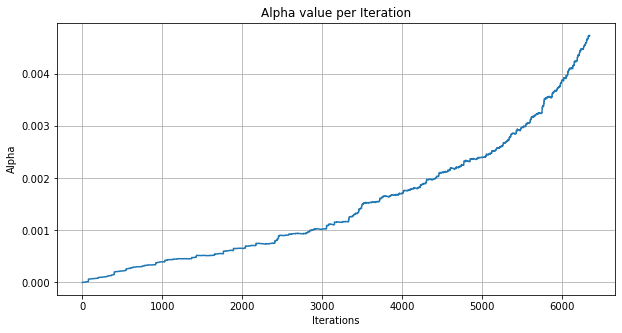

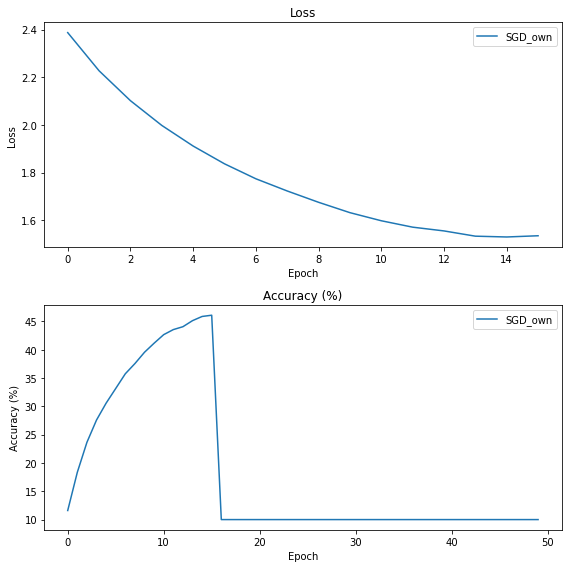

In [15]:
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torchvision.transforms as transforms
from torchvision import datasets
import copy
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt

gamma = 0.999

def compute_step_size(X, W, gradient, Y_hot):
    global past_10th_epoch

    if past_10th_epoch:
        return compute_step_size.avg_step_size * 10 ###############################

    W = W.t()
    gradient = gradient.t()
    term1 = torch.sum(torch.exp(-torch.mm(X, W)), dim=1)
    term2 = torch.sum(torch.mm(X, gradient), dim=1)
    term3 = torch.exp(-torch.sum(X * (torch.mm(Y_hot, torch.transpose(W, 0, 1))), dim=1))
    term4 = torch.sum(X * (torch.mm(Y_hot, torch.transpose(gradient, 0, 1))), dim=1)
    
    a = ((term1 * (term2**2)) - (term3 * (term4**2))) / 2
    b = (term1 * term2) - (term3 * term4)
    c = (term1 - term3) - ((term2 * term1 / term4) - (term3))

    alpha = torch.mean(torch.abs((-b + torch.sqrt(b**2 - 4*a*c)) / (2*a))) * 0.0001
    
    alpha = torch.clamp(alpha, 0.00005, 0.05)          #############################
    
    if not hasattr(compute_step_size, "avg_step_size"):
        compute_step_size.avg_step_size = 0
        
    compute_step_size.avg_step_size = gamma * compute_step_size.avg_step_size + (1 - gamma) * alpha.item()
    
    return compute_step_size.avg_step_size

class SGD_own(Optimizer):
    def __init__(self, params, lr=1e-2):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SGD_own, self).__init__(params, defaults)
        self.alphas = [] 

    def step(self, X, W, gradient, Y_hot, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        lr_last_layer = compute_step_size(X, W, gradient, Y_hot)
        lr_first_layer = lr_last_layer * 0.01  # Scaling first layer #################
        
        self.alphas.append(lr_last_layer)
        
        num_layers = len(self.param_groups[0]['params'])
        
        for group in self.param_groups:
            for idx, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                # Linear interpolation of the learning rate based on the layer index
                lr_scale = idx / (num_layers - 1)
                lr_current_layer = lr_first_layer + lr_scale * (lr_last_layer - lr_first_layer)
                
                p.data.add_(d_p, alpha=-lr_current_layer)
        
        return loss


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ResNet18Wrapper(nn.Module):
    def __init__(self):
        super(ResNet18Wrapper, self).__init__()
        self.resnet = resnet18(weights=None)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 10)  # 10 classes CIFAR10

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        
        self.features_before_fc = x
        x = self.resnet.fc(self.features_before_fc)
        return F.log_softmax(x, dim=1)
    

def evaluate_model(model, loader, criterion):
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        avg_loss = running_loss / len(loader)
        avg_accuracy = correct / total * 100
    return avg_loss, avg_accuracy



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

model = ResNet18Wrapper().to(device)
original_model_state = copy.deepcopy(model.state_dict())

criterion = nn.CrossEntropyLoss()
initial_loss, initial_accuracy = evaluate_model(model, trainloader, criterion)

optimizers = {'SGD_own': SGD_own(model.parameters(), lr=0.01),
}


history = {}

for name, optimizer in optimizers.items():
    print(f'---- {name} ----')
    model.load_state_dict(copy.deepcopy(original_model_state))

    epoch_losses = []
    epoch_accuracies = []
    time_points = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    
    start_time = time.time()
    epoch_losses.append(initial_loss)
    epoch_accuracies.append(initial_accuracy)
    time_points.append(0)
    
    past_10th_epoch = False

            
    for epoch in range(50):
        if epoch == 40: ##################################################################################
            past_10th_epoch = True
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            X = model.features_before_fc
            W = model.resnet.fc.weight.data  # This is the last layer's weight
            gradient = model.resnet.fc.weight.grad.data
            Y_hot = F.one_hot(labels, num_classes=10).float()

            optimizer.step(X, W, gradient, Y_hot)
            
            

        test_epoch_loss, test_epoch_accuracy = evaluate_model(model, testloader, criterion)
        test_epoch_losses.append(test_epoch_loss)
        test_epoch_accuracies.append(test_epoch_accuracy)
        print(f'Test Epoch {epoch + 1}, loss: {test_epoch_loss}, accuracy: {test_epoch_accuracy}%')
        
    print('Training finished. Time elapsed: ', time.time() - start_time)
    
    history[name] = {'train_loss': epoch_losses, 
                     'train_accuracy': epoch_accuracies, 
                     'test_loss': test_epoch_losses, 
                     'test_accuracy': test_epoch_accuracies, 
                     'time': time_points}

    
plt.figure(figsize=(10, 5))
plt.plot(optimizers['SGD_own'].alphas)
plt.xlabel('Iterations')
plt.ylabel('Alpha')
plt.title('Alpha value per Iteration')
plt.grid(True)
plt.show()


fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 8))

for name, hist in history.items():
    ax1.plot(hist['test_loss'], label=name)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(hist['test_accuracy'], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy (%)')
    ax2.legend()


plt.tight_layout()
plt.show()

# CON 0.01 LAYER SCALING  CLIPPING 0.02 BETA 0.999 SCALING 10^-3

Files already downloaded and verified
Files already downloaded and verified
---- SGD_own ----
Test Epoch 1, loss: 2.396603373032582, accuracy: 12.49%
Test Epoch 2, loss: 2.248575340343427, accuracy: 17.86%
Test Epoch 3, loss: 2.127330754376665, accuracy: 22.37%
Test Epoch 4, loss: nan, accuracy: 10.0%
Test Epoch 5, loss: nan, accuracy: 10.0%
Test Epoch 6, loss: nan, accuracy: 10.0%
Test Epoch 7, loss: nan, accuracy: 10.0%
Test Epoch 8, loss: nan, accuracy: 10.0%
Test Epoch 9, loss: nan, accuracy: 10.0%
Test Epoch 10, loss: nan, accuracy: 10.0%
Test Epoch 11, loss: nan, accuracy: 10.0%
Test Epoch 12, loss: nan, accuracy: 10.0%
Test Epoch 13, loss: nan, accuracy: 10.0%
Test Epoch 14, loss: nan, accuracy: 10.0%
Test Epoch 15, loss: nan, accuracy: 10.0%
Test Epoch 16, loss: nan, accuracy: 10.0%
Test Epoch 17, loss: nan, accuracy: 10.0%
Test Epoch 18, loss: nan, accuracy: 10.0%
Test Epoch 19, loss: nan, accuracy: 10.0%
Test Epoch 20, loss: nan, accuracy: 10.0%
Test Epoch 21, loss: nan, accu

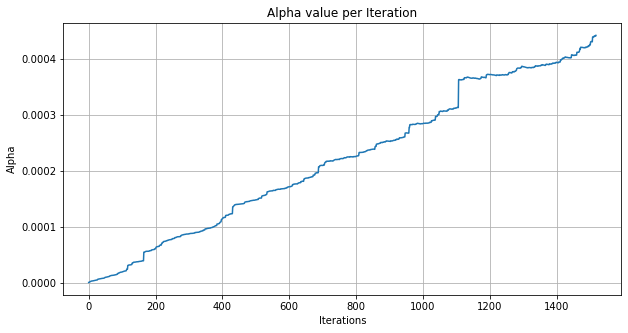

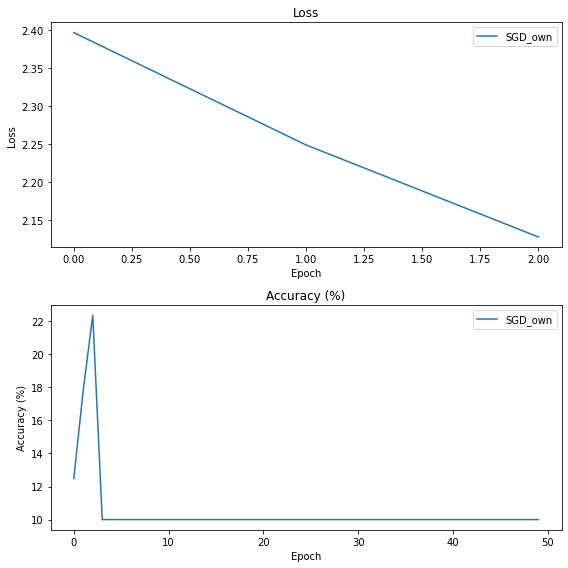

In [16]:
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torchvision.transforms as transforms
from torchvision import datasets
import copy
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt

gamma = 0.999

def compute_step_size(X, W, gradient, Y_hot):
    global past_10th_epoch

    if past_10th_epoch:
        return compute_step_size.avg_step_size * 10 ###############################

    W = W.t()
    gradient = gradient.t()
    term1 = torch.sum(torch.exp(-torch.mm(X, W)), dim=1)
    term2 = torch.sum(torch.mm(X, gradient), dim=1)
    term3 = torch.exp(-torch.sum(X * (torch.mm(Y_hot, torch.transpose(W, 0, 1))), dim=1))
    term4 = torch.sum(X * (torch.mm(Y_hot, torch.transpose(gradient, 0, 1))), dim=1)
    
    a = ((term1 * (term2**2)) - (term3 * (term4**2))) / 2
    b = (term1 * term2) - (term3 * term4)
    c = (term1 - term3) - ((term2 * term1 / term4) - (term3))

    alpha = torch.mean(torch.abs((-b + torch.sqrt(b**2 - 4*a*c)) / (2*a))) * 0.0001
    
    alpha = torch.clamp(alpha, 0.00005, 0.05)          #############################
    
    if not hasattr(compute_step_size, "avg_step_size"):
        compute_step_size.avg_step_size = 0
        
    compute_step_size.avg_step_size = gamma * compute_step_size.avg_step_size + (1 - gamma) * alpha.item()
    
    return compute_step_size.avg_step_size

class SGD_own(Optimizer):
    def __init__(self, params, lr=1e-2):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SGD_own, self).__init__(params, defaults)
        self.alphas = [] 

    def step(self, X, W, gradient, Y_hot, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        lr_last_layer = compute_step_size(X, W, gradient, Y_hot)
        lr_first_layer = lr_last_layer * 0.01  # Scaling first layer #################
        
        self.alphas.append(lr_last_layer)
        
        num_layers = len(self.param_groups[0]['params'])
        
        for group in self.param_groups:
            for idx, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                # Linear interpolation of the learning rate based on the layer index
                lr_scale = idx / (num_layers - 1)
                lr_current_layer = lr_first_layer + lr_scale * (lr_last_layer - lr_first_layer)
                
                p.data.add_(d_p, alpha=-lr_current_layer)
        
        return loss


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ResNet18Wrapper(nn.Module):
    def __init__(self):
        super(ResNet18Wrapper, self).__init__()
        self.resnet = resnet18(weights=None)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 10)  # 10 classes CIFAR10

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        
        self.features_before_fc = x
        x = self.resnet.fc(self.features_before_fc)
        return F.log_softmax(x, dim=1)
    

def evaluate_model(model, loader, criterion):
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        avg_loss = running_loss / len(loader)
        avg_accuracy = correct / total * 100
    return avg_loss, avg_accuracy



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

model = ResNet18Wrapper().to(device)
original_model_state = copy.deepcopy(model.state_dict())

criterion = nn.CrossEntropyLoss()
initial_loss, initial_accuracy = evaluate_model(model, trainloader, criterion)

optimizers = {'SGD_own': SGD_own(model.parameters(), lr=0.01),
}


history = {}

for name, optimizer in optimizers.items():
    print(f'---- {name} ----')
    model.load_state_dict(copy.deepcopy(original_model_state))

    epoch_losses = []
    epoch_accuracies = []
    time_points = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    
    start_time = time.time()
    epoch_losses.append(initial_loss)
    epoch_accuracies.append(initial_accuracy)
    time_points.append(0)
    
    past_10th_epoch = False

            
    for epoch in range(50):
        if epoch == 40: ##################################################################################
            past_10th_epoch = True
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            X = model.features_before_fc
            W = model.resnet.fc.weight.data  # This is the last layer's weight
            gradient = model.resnet.fc.weight.grad.data
            Y_hot = F.one_hot(labels, num_classes=10).float()

            optimizer.step(X, W, gradient, Y_hot)
            
            

        test_epoch_loss, test_epoch_accuracy = evaluate_model(model, testloader, criterion)
        test_epoch_losses.append(test_epoch_loss)
        test_epoch_accuracies.append(test_epoch_accuracy)
        print(f'Test Epoch {epoch + 1}, loss: {test_epoch_loss}, accuracy: {test_epoch_accuracy}%')
        
    print('Training finished. Time elapsed: ', time.time() - start_time)
    
    history[name] = {'train_loss': epoch_losses, 
                     'train_accuracy': epoch_accuracies, 
                     'test_loss': test_epoch_losses, 
                     'test_accuracy': test_epoch_accuracies, 
                     'time': time_points}

    
plt.figure(figsize=(10, 5))
plt.plot(optimizers['SGD_own'].alphas)
plt.xlabel('Iterations')
plt.ylabel('Alpha')
plt.title('Alpha value per Iteration')
plt.grid(True)
plt.show()


fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 8))

for name, hist in history.items():
    ax1.plot(hist['test_loss'], label=name)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(hist['test_accuracy'], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy (%)')
    ax2.legend()


plt.tight_layout()
plt.show()

# PROBAR DATA AUGMENTATION